In [1]:
import requests
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
# from pyproj import Proj, transform
import numpy as np
import math
from operator import itemgetter
import gurobipy as grb
# import sys
# !{sys.executable} -m pip install geopy
from geopy.distance import distance, lonlat
import pyproj
from shapely.geometry import Point
from shapely.ops import transform

In [2]:
inProj = pyproj.Proj(init='epsg:3414')
outProj = pyproj.Proj(init='epsg:4326')
    
def transform_coor(x, y):
    x2, y2 = pyproj.transform(inProj, outProj, x, y)
    return x2, y2

C:\Users\berna\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\berna\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [3]:
loc_raw = pd.read_csv("hdb-carpark-information.csv")
carpark_loc = loc_raw[['car_park_no', 'x_coord', 'y_coord']]

In [4]:
response = requests.get("https://api.data.gov.sg/v1/transport/carpark-availability")
carpark_info_raw = response.json()['items'][0]['carpark_data']
carpark_info_ls = [{
    'car_park_no': x['carpark_number'], 
    'total_lots': sum([int(cp['total_lots']) for cp in x['carpark_info']])
} for x in carpark_info_raw]
carpark_info_dict = {key: [i[key] for i in carpark_info_ls] for key in carpark_info_ls[0]}
carpark_info = pd.DataFrame.from_dict(carpark_info_dict)

In [5]:
carpark_combined = pd.merge(carpark_info, carpark_loc, how='left').dropna()

In [6]:
carpark_subset = carpark_combined[['total_lots', 'x_coord', 'y_coord']]
carpark_subset.head()

,total_lots,x_coord,y_coord
0,105,26367.5806,30069.2434
1,583,29354.6692,29687.5080
2,329,26359.4531,29876.1692
3,97,26194.9184,29563.3295
4,96,23531.2041,32206.3235


In [7]:
new_x = []
new_y = []

for i in range(len(carpark_subset)):
    x_coord = carpark_subset.iloc[i][['x_coord']][0]
    y_coord = carpark_subset.iloc[i][['y_coord']][0]
    n_x, n_y = transform_coor(x_coord, y_coord)
    new_x.append(n_x)
    new_y.append(n_y)

carpark_transformed = carpark_subset.copy()
carpark_transformed['x_coord'] = pd.Series(new_x)
carpark_transformed['y_coord'] = pd.Series(new_y)

C:\Users\berna\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """


In [8]:
total_n_cars = 853022
sum_carpark_lots = sum(carpark_transformed['total_lots'])

carpark_scaled = carpark_transformed.copy()
carpark_scaled['total_lots'] = (carpark_scaled['total_lots'] * total_n_cars / sum_carpark_lots).astype(int)
carpark_scaled.dropna()

,total_lots,x_coord,y_coord
0,124,103.818651,1.288210
1,690,103.845491,1.284758
2,389,103.818578,1.286464
3,114,103.817099,1.283635
4,113,103.793164,1.307537
...,...,...,...
1916,184,103.834407,1.362364
1917,1141,103.835476,1.363186
1918,11,103.927947,1.324792
1919,394,103.872186,1.340253


In [9]:
carpark_scaled = carpark_scaled.dropna()
gdf = geopandas.GeoDataFrame(
    carpark_scaled, geometry=geopandas.points_from_xy(carpark_scaled['x_coord'], carpark_scaled['y_coord']))[['total_lots', 'geometry']]

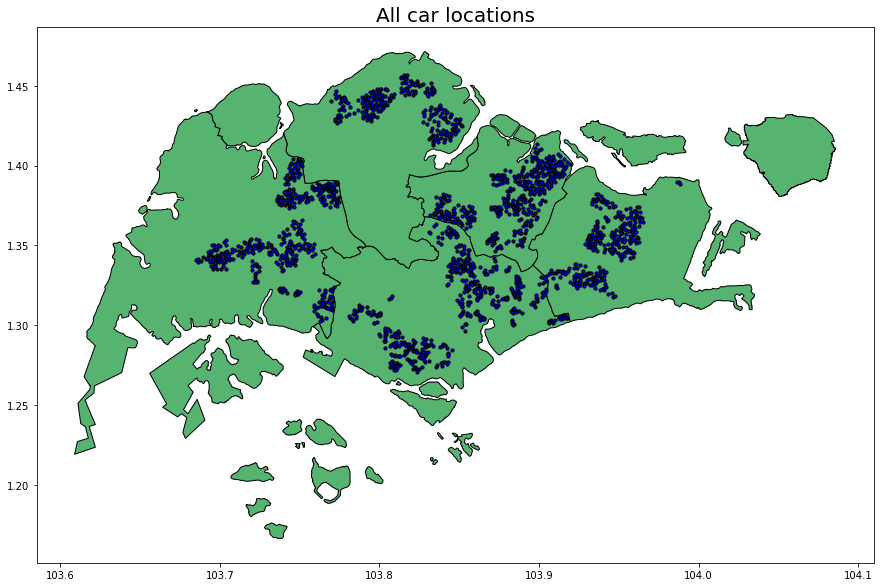

In [10]:
map_color = "#57b370"

sg_map = geopandas.read_file('SGP_adm1.shp')
ax = sg_map.plot(color=map_color, edgecolor='black',  figsize=(15, 10))
gdf.plot(ax=ax, color='blue',markersize = 10, edgecolor = 'black')
plt.title("All car locations", fontsize = 20)
# gdf.plot(ax=ax, cmap = 'Blues', markersize=gdf['total_lots'], alpha = 0.5, edgecolor = 'black')

plt.show()

In [11]:
def sigmoid(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

num_years = 19
proportions = []
proportions = proportions[1:]

L = 1
k = 0.5
x0 = num_years / 2

for year in range(num_years):
    proportion = sigmoid(year, L, k, x0)
    proportions.append(proportion)

df = carpark_scaled.copy()

ev_df_ls = []

for i, p in enumerate(proportions):
    new_append = df.copy()
    
    new_append['total_lots'] = (proportions[i] * df['total_lots'] if i == 0 else (
        np.maximum(proportions[i] * df['total_lots'], ev_df_ls[i - 1]['total_lots'])
    )).astype(int)
    
    ev_df_ls.append(new_append)

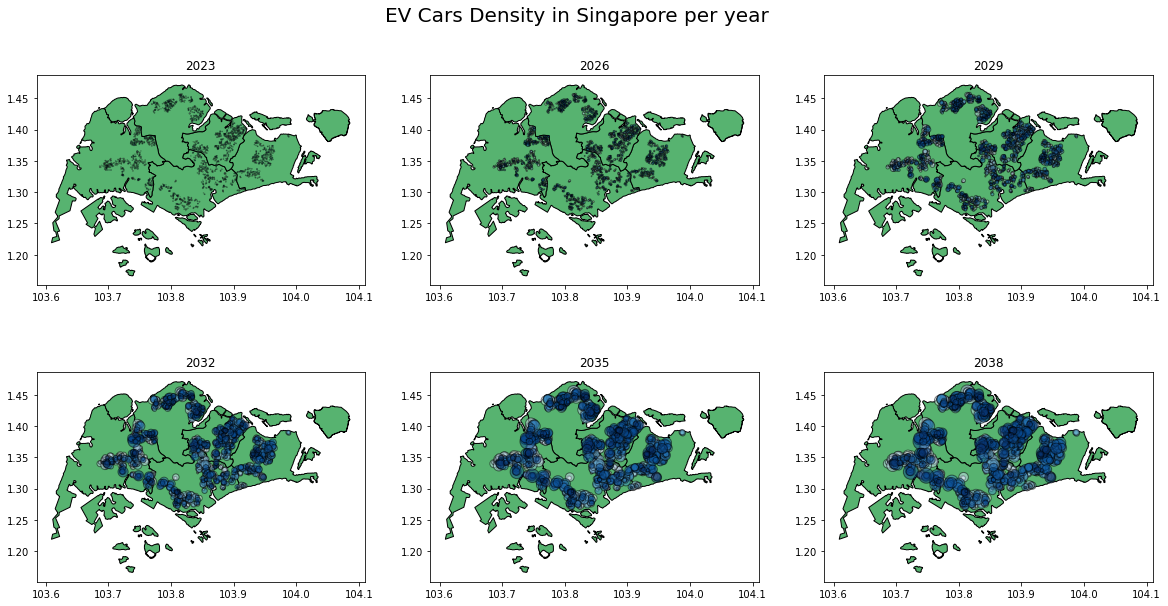

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('EV Cars Density in Singapore per year', fontsize=20, y = 0.95)
for i, axs_row in enumerate(axs):
    for j, ax in enumerate(axs_row):
        rank = i * 3 + j
        index = rank * 3
        ax.set_title(str(index + 2023))
        sg_map.plot(ax = ax, color=map_color, edgecolor='black')
        gdf.plot(ax = ax, cmap = 'Blues', markersize=ev_df_ls[index]['total_lots'] / 10, alpha = 0.5, edgecolor = 'black')

In [13]:
bounds = sg_map.geometry.apply(lambda x: x.bounds).tolist()

np.random.seed(99)

minx, miny, maxx, maxy = min(bounds, key=itemgetter(0))[0], min(bounds, key=itemgetter(1))[1], max(bounds, key=itemgetter(2))[2], max(bounds, key=itemgetter(3))[3]
minx = 103.68
maxx = 104.01
miny = 1.25

points = []

xpace = (maxx - minx) / 19 / 5
yspace = (maxy - miny) / 19 / 5

for x in np.linspace(minx, maxx, 20):
    for y in np.linspace(miny, maxy, 20):
        p = geopandas.points_from_xy([x + np.random.normal(0, xpace)], [y + np.random.normal(0, yspace)])
        points.append(p[0])

In [14]:
# K = np.array([[1, 2, 3], [4, 5, 6]])
# Q = np.array([[1, 2, 3], [4, 5, 6]])
# K @ Q

246


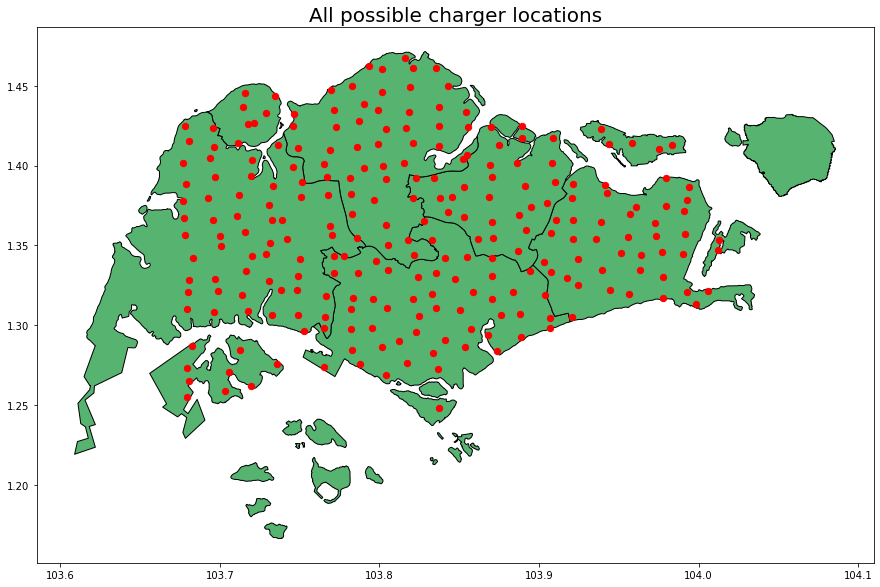

In [15]:
points_within_sg = [point for point in points if sg_map['geometry'].contains(point).any()]
points_within_sg = geopandas.GeoSeries(points_within_sg)

ax = sg_map.plot(color=map_color, edgecolor='black',  figsize=(15, 10))
# gdf.plot(ax=ax, cmap = 'Blues', markersize=gdf['total_lots'], alpha = 0.5, edgecolor = 'black')
points_within_sg.plot(ax=ax, color = 'red', markersize = 40)
plt.title("All possible charger locations", fontsize = 20)

print(len(points_within_sg))
plt.show()

In [16]:
MAX_DIST = 1.5
MAX_CAPACITY_L2 = 100
MAX_CAPACITY_L3 = 400
F_COST = 300
V_COST_L2 = 12000
V_COST_L3 = 36000
M_COST = 200

In [17]:
# Simpler problem: Only 1 EV/location, there is no max capacity
len_c = len(points_within_sg)
len_loc = len(gdf)

A = np.zeros((len_loc, len_c))

for l in range(len_loc):
    for c in range(len_c):
        dist_in_km = distance(lonlat(*(points_within_sg[c].coords[0])), lonlat(*(gdf.iloc[l]['geometry'].coords[0]))).km
        if dist_in_km <= MAX_DIST:
            A[l, c] = 1

In [18]:
m = grb.Model('Simpler')
C = m.addMVar((len_c), vtype = grb.GRB.BINARY, name = 'C')

m.setObjective(C.sum(), sense = grb.GRB.MINIMIZE)

total = A @ C

for i in range(len_loc):
    m.addConstr(total[i] >= 1)
    
m.optimize()

C_ans = C.X

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-13
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1915 rows, 246 columns and 5256 nonzeros
Model fingerprint: 0x67868519
Variable types: 0 continuous, 246 integer (246 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 60.0000000
Presolve removed 1915 rows and 246 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 58 60 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.800000000000e+01, 

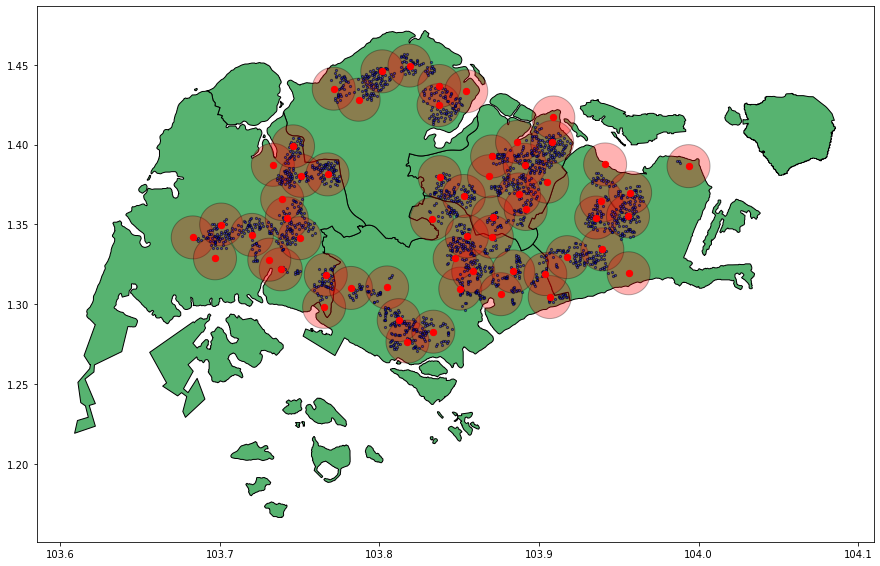

58


In [19]:
C_ans_int = C_ans.astype(int)
C_ans_ind = [i for i, x in enumerate(C_ans_int) if x == 1]
ans = points_within_sg.iloc[C_ans_ind]
circles =  geopandas.GeoSeries([x.buffer(0.0089832 * MAX_DIST) for x in ans])

ax = sg_map.plot(color=map_color, edgecolor='black',  figsize=(15, 10))
circles.plot(ax=ax, color = 'red', alpha = 0.3, edgecolor = 'black')
gdf.plot(ax=ax, color = "blue", markersize=5, alpha = 0.5, edgecolor = 'black')
ans.plot(ax=ax, color = 'red', markersize = 40)

plt.show()
print(len(ans))

In [20]:
# Harder problem: > 1 EV/loc, Capacity Limited
m = grb.Model('Harder')
C = m.addMVar((len_c), vtype = grb.GRB.INTEGER, name = 'C')
B = m.addMVar((len_loc, len_c), vtype = grb.GRB.INTEGER, name = 'B')
D = np.array(gdf['total_lots'])

m.setObjective(C.sum(), sense = grb.GRB.MINIMIZE)

pw_mult = A * B

for j in range(len_c):
    m.addConstr(B[:, j].sum() <= MAX_CAPACITY_L2 * C[j])

for i in range(len_loc):
    m.addConstr(pw_mult[i, :].sum() >= D[i])

m.optimize()

C_ans = C.X
B_ans = B.X

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2161 rows, 471336 columns and 476592 nonzeros
Model fingerprint: 0xf3e71076
Variable types: 0 continuous, 471336 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+03]
Found heuristic solution: objective 8570.0000000
Presolve removed 482 rows and 466821 columns
Presolve time: 0.27s
Presolved: 1679 rows, 4515 columns, 8901 nonzeros
Found heuristic solution: objective 8516.0000000
Variable types: 0 continuous, 4515 integer (0 binary)

Root relaxation: objective 8.500310e+03, 2678 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntIn

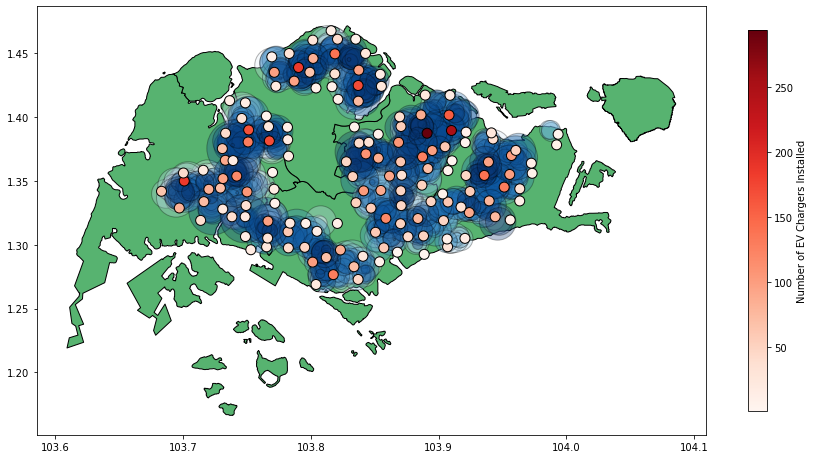

150


In [21]:
C_ans_int = C_ans.astype(int)
C_ans_ind = [i for i, x in enumerate(C_ans_int) if x > 0]
C_ans_w = [x for x in C_ans_int if x != 0]
ans = points_within_sg.iloc[C_ans_ind]

ans_df = geopandas.GeoDataFrame(geometry=ans)
ans_df['n'] = np.array(C_ans_w)

vmax, vmin = max(C_ans_w), min(C_ans_w)

ax = sg_map.plot(color=map_color, edgecolor='black',  figsize=(15, 10))
gdf.plot(ax=ax, cmap = 'Blues', markersize=gdf['total_lots'], alpha = 0.3, edgecolor = 'black')
ans_df.plot(ax=ax, cmap = 'Reds', column = 'n', 
            markersize = 100, edgecolor = 'black', 
            vmax = vmax, vmin = vmin, legend = True,
            legend_kwds={'label': "Number of EV Chargers Installed", "shrink": 0.7}
           )

plt.show()
print(len(ans))

In [22]:
sum(C_ans_w)

8501

In [23]:
# Even harder problem: > 1 EV/loc, Capacity Limited, + Fixed Cost
m = grb.Model('Even Harder')
m.Params.TimeLimit = 30
C = m.addMVar((len_c), vtype = grb.GRB.INTEGER, name = 'C')
Y = m.addMVar((len_c), vtype = grb.GRB.BINARY, name = 'Y')
B = m.addMVar((len_loc, len_c), vtype = grb.GRB.INTEGER, name = 'B')
D = np.array(gdf['total_lots'])
M = float(1e5)

m.setObjective(C.sum() * V_COST_L2 + Y.sum() * F_COST, sense = grb.GRB.MINIMIZE)

pw_mult = A * B

for j in range(len_c):
    m.addConstr(B[:, j].sum() <= MAX_CAPACITY_L2 * C[j])
    m.addConstr(C[j] <= M * Y[j])

for i in range(len_loc):
    m.addConstr(pw_mult[i, :].sum() >= D[i])

m.optimize()

C_ans = C.X
B_ans = B.X

Set parameter TimeLimit to value 30
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2407 rows, 471582 columns and 477084 nonzeros
Model fingerprint: 0x69cc3030
Variable types: 0 continuous, 471582 integer (246 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [3e+02, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 3e+03]
Found heuristic solution: objective 1.029435e+08
Presolve removed 314 rows and 466156 columns
Presolve time: 3.69s
Presolved: 2093 rows, 5426 columns, 10700 nonzeros
Variable types: 0 continuous, 5426 integer (130 binary)

Root relaxation: objective 1.020057e+08, 4811 iterations, 0.05 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

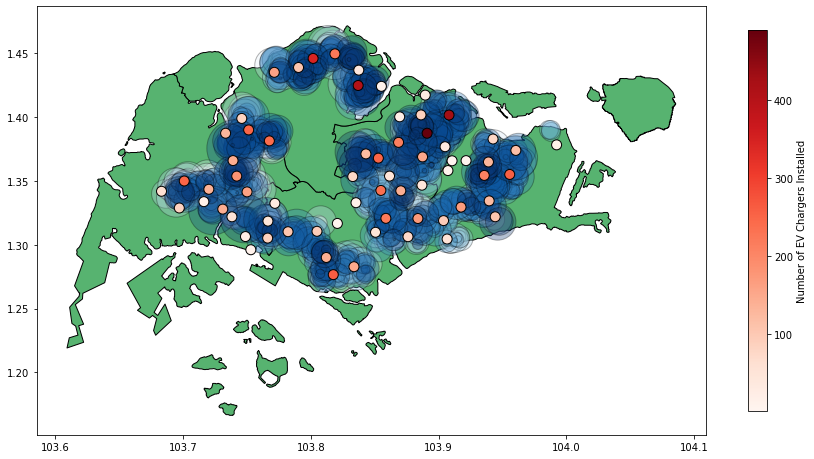

66


In [24]:
C_ans_int = C_ans.astype(int)
C_ans_ind = [i for i, x in enumerate(C_ans_int) if x > 0]
C_ans_w = [x for x in C_ans_int if x != 0]
ans = points_within_sg.iloc[C_ans_ind]

ans_df = geopandas.GeoDataFrame(geometry=ans)
ans_df['n'] = np.array(C_ans_w)

vmax, vmin = max(C_ans_w), min(C_ans_w)

ax = sg_map.plot(color=map_color, edgecolor='black',  figsize=(15, 10))
gdf.plot(ax=ax, cmap = 'Blues', markersize=gdf['total_lots'], alpha = 0.3, edgecolor = 'black')
ans_df.plot(ax=ax, cmap = 'Reds', column = 'n', 
            markersize = 100, edgecolor = 'black', 
            vmax = vmax, vmin = vmin, legend = True,
            legend_kwds={'label': "Number of EV Chargers Installed", "shrink": 0.7}
           )

plt.show()
print(len(ans))

In [25]:
sum(C_ans_w)

8501

In [26]:
# Even harder^2 problem: > 1 EV/loc, Capacity Limited, + Fixed Cost, 2 kinds of Chargers
m = grb.Model('Even Harder^2')
m.Params.TimeLimit = 30

C2 = m.addMVar((len_c), vtype = grb.GRB.INTEGER, name = 'C2')
B2 = m.addMVar((len_loc, len_c), vtype = grb.GRB.INTEGER, name = 'B2')

C3 = m.addMVar((len_c), vtype = grb.GRB.INTEGER, name = 'C3')
B3 = m.addMVar((len_loc, len_c), vtype = grb.GRB.INTEGER, name = 'B3')

Y = m.addMVar((len_c), vtype = grb.GRB.BINARY, name = 'Y')

D = np.array(ev_df_ls[2]['total_lots'])
M = float(1e5)

m.setObjective(C2.sum() * V_COST_L2 + C3.sum() * V_COST_L3 + Y.sum() * F_COST, sense = grb.GRB.MINIMIZE)

pw_mult_1 = A * B2
pw_mult_2 = A * B3
pw_mult = pw_mult_1 + pw_mult_2

for j in range(len_c):
    m.addConstr(B2[:, j].sum() <= MAX_CAPACITY_L2 * C2[j])
    m.addConstr(B3[:, j].sum() <= MAX_CAPACITY_L3 * C3[j])
    m.addConstr(C2[j] + C3[j] <= M * Y[j])

for i in range(len_loc):
    m.addConstr(pw_mult[i, :].sum() >= D[i])

m.optimize()

C2_ans = C2.X
C3_ans = C3.X
B2_ans = B2.X

Set parameter TimeLimit to value 30
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2653 rows, 942918 columns and 953922 nonzeros
Model fingerprint: 0xa896f49a
Variable types: 0 continuous, 942918 integer (246 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [3e+02, 4e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Found heuristic solution: objective 7148700.0000
Presolve removed 413 rows and 932640 columns
Presolve time: 3.56s
Presolved: 2240 rows, 10278 columns, 20426 nonzeros
Variable types: 0 continuous, 10278 integer (130 binary)

Root relaxation: objective 1.690650e+06, 5815 iterations, 0.07 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In


Solution count 10: 1.9143e+06 1.9383e+06 1.9389e+06 ... 2.0124e+06

Time limit reached
Best objective 1.914300000000e+06, best bound 1.779000000000e+06, gap 7.0679%


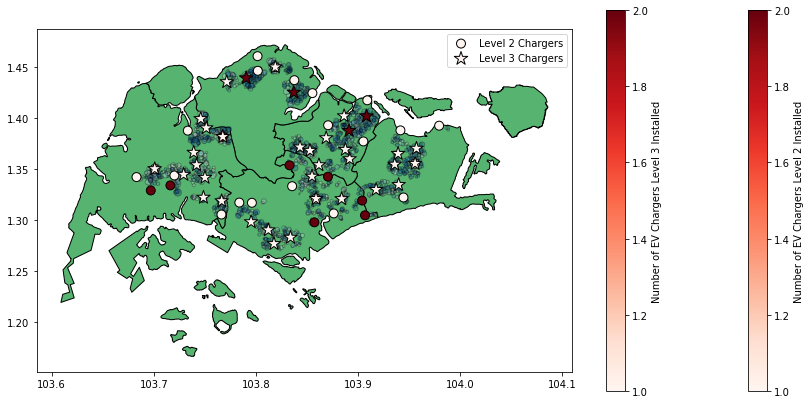

30


In [27]:
# C2
C2_ans_int = C2_ans.astype(int)
C2_ans_ind = [i for i, x in enumerate(C2_ans_int) if x > 0]
C2_ans_w = [x for x in C2_ans_int if x != 0]
ans2 = points_within_sg.iloc[C2_ans_ind]

ans_df2 = geopandas.GeoDataFrame(geometry=ans2)
ans_df2['n'] = np.array(C2_ans_w)

vmax2, vmin2 = max(C2_ans_w), min(C2_ans_w)

# C3
C3_ans_int = C3_ans.astype(int)
C3_ans_ind = [i for i, x in enumerate(C3_ans_int) if x > 0]
C3_ans_w = [x for x in C3_ans_int if x != 0]
ans3 = points_within_sg.iloc[C3_ans_ind]

ans_df3 = geopandas.GeoDataFrame(geometry=ans3)
ans_df3['n'] = np.array(C3_ans_w)

vmax3, vmin3 = max(C3_ans_w), min(C3_ans_w)

# Plotting
ax = sg_map.plot(color=map_color, edgecolor='black',  figsize=(15, 10))
gdf.plot(ax=ax, cmap = 'Blues', markersize=ev_df_ls[2]['total_lots'], alpha = 0.3, edgecolor = 'black')
ans_df2.plot(ax=ax, cmap = 'Reds', column = 'n', 
            markersize = 80, edgecolor = 'black', label = 'Level 2 Chargers',
            vmax = vmax2, vmin = vmin2, legend = True,
            legend_kwds={'label': "Number of EV Chargers Level 2 Installed", "shrink": 0.7}
           )
ans_df3.plot(ax=ax, cmap = 'Reds', column = 'n', marker = '*',
            markersize = 200, edgecolor = 'black', label = 'Level 3 Chargers',
            vmax = vmax3, vmin = vmin3, legend = True,
            legend_kwds={'label': "Number of EV Chargers Level 3 Installed", "shrink": 0.7}
           )
ax.legend()

plt.show()
print(len(ans2))

In [28]:
# The behemoth final problem: > 1 EV/loc, Capacity Limited, + Fixed Cost, 2 kinds of Chargers, 18 years + maintenance cost + changing costs
m = grb.Model('Even Harder^3')
m.Params.TimeLimit = 300

len_years = len(ev_df_ls)

C2 = m.addMVar((len_years + 1, len_c), vtype = grb.GRB.INTEGER, name = 'C2')
C2_diff = C2[1:, :] - C2[0:len_years, :]
B2 = m.addMVar((len_years, len_loc, len_c), vtype = grb.GRB.INTEGER, name = 'B2')

C3 = m.addMVar((len_years + 1, len_c), vtype = grb.GRB.INTEGER, name = 'C3')
C3_diff = C3[1:, :] - C3[0:len_years, :]
B3 = m.addMVar((len_years, len_loc, len_c), vtype = grb.GRB.INTEGER, name = 'B3')

Y = m.addMVar((len_years, len_c), vtype = grb.GRB.BINARY, name = 'Y')

D = np.array([x['total_lots'] for x in ev_df_ls])
M = float(1e5)

L2_costs = np.linspace(V_COST_L2, 0.5 * V_COST_L2, len_years)
L3_costs = np.linspace(V_COST_L3, 0.8 * V_COST_L3, len_years)

m.setObjective((L2_costs @ C2_diff).sum() + (L3_costs @ C3_diff).sum() + 
               Y.sum() * F_COST + (C2.sum() + C3.sum()) * M_COST, sense = grb.GRB.MINIMIZE)

m.addConstr((C2[0]).sum() == 0)
m.addConstr((C3[0]).sum() == 0)

m.addConstr(C2_diff >= 0)
m.addConstr(C3_diff >= 0)

for y in range(len_years):
    pw_mult_1 = A * B2[y]
    pw_mult_2 = A * B3[y]
    pw_mult = pw_mult_1 + pw_mult_2

    for j in range(len_c):
        m.addConstr(B2[y, :, j].sum() <= MAX_CAPACITY_L2 * C2[y + 1, j])
        m.addConstr(B3[y, :, j].sum() <= MAX_CAPACITY_L3 * C3[y + 1, j])
        m.addConstr(C2_diff[y, j] + C3_diff[y, j] <= M * Y[y, j])

    for i in range(len_loc):
        m.addConstr(pw_mult[i, :].sum() >= D[y, i])

m.optimize()

C2_ans = C2.X
C3_ans = C3.X

In [29]:
# m.optimize()
# C2_ans = C2.X

# for i in range(1, len(C2_ans)):
#     print(C3_ans[i] - C3_ans[i - 1])

In [30]:
# C2_ans = np.array(C2.X)
# C3_ans = np.array(C3.X)

# np.save('C2', C2_ans)
# np.save('C3', C3_ans)

In [31]:
C2_ans = np.load("C2.npy")
C3_ans = np.load("C3.npy")

In [32]:
def plot_custom(C2_ans, C3_ans, yr = None, ax = None):
    # C2
    C2_ans_int = C2_ans.astype(int)
    C2_ans_ind = [i for i, x in enumerate(C2_ans_int) if x > 0]
    C2_ans_w = [x for x in C2_ans_int if x != 0]
    ans2 = points_within_sg.iloc[C2_ans_ind]

    ans_df2 = geopandas.GeoDataFrame(geometry=ans2)
    ans_df2['n'] = np.array(C2_ans_w)

    vmax2, vmin2 = (max(C2_ans_w), min(C2_ans_w)) if len(C2_ans_w) > 0 else (0, 0)

    # C3
    C3_ans_int = C3_ans.astype(int)
    C3_ans_ind = [i for i, x in enumerate(C3_ans_int) if x > 0]
    C3_ans_w = [x for x in C3_ans_int if x != 0]
    ans3 = points_within_sg.iloc[C3_ans_ind]

    ans_df3 = geopandas.GeoDataFrame(geometry=ans3)
    ans_df3['n'] = np.array(C3_ans_w)

    vmax3, vmin3 = (max(C3_ans_w), min(C3_ans_w)) if len(C3_ans_w) > 0 else (0, 0)

    # Plotting
    if ax != None:
        sg_map.plot(ax = ax, color=map_color, edgecolor='black',  figsize=(15, 10))
    else:
        ax = sg_map.plot(color=map_color, edgecolor='black',  figsize=(15, 10))
    gdf.plot(ax=ax, cmap = 'Blues', markersize=ev_df_ls[2]['total_lots'], alpha = 0.3, edgecolor = 'black')
    ax.set_title(str(yr))
    ans_df3.plot(ax=ax, cmap = 'Reds', column = 'n', marker = '*',
                markersize = 200, edgecolor = 'black', label = 'Level 3 Chargers',
                vmax = vmax3, vmin = vmin3, legend = True,
                legend_kwds={'label': "Number of EV Chargers Level 3 Installed", "shrink": 0.7}
                )
    ans_df2.plot(ax=ax, cmap = 'Reds', column = 'n', 
                markersize = 80, edgecolor = 'black', label = 'Level 2 Chargers',
                vmax = vmax2, vmin = vmin2, legend = True,
                legend_kwds={'label': "Number of EV Chargers Level 2 Installed", "shrink": 0.7}
                )
    ax.legend()

C:\Users\berna\anaconda3\lib\site-packages\geopandas\plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\berna\anaconda3\lib\site-packages\geopandas\plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


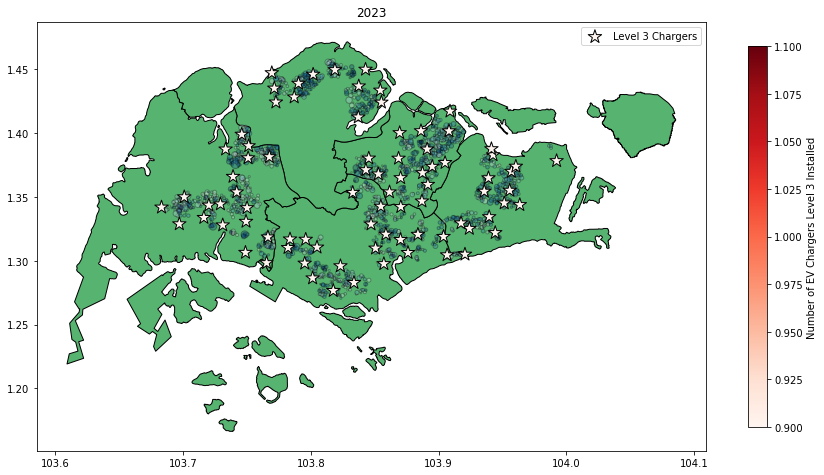

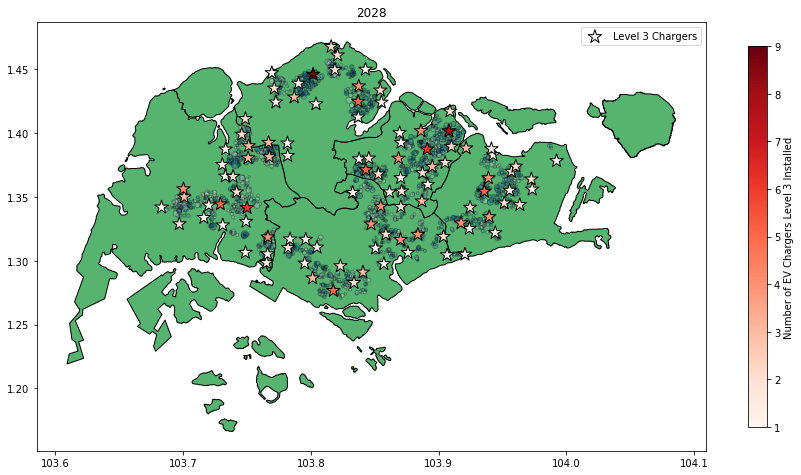

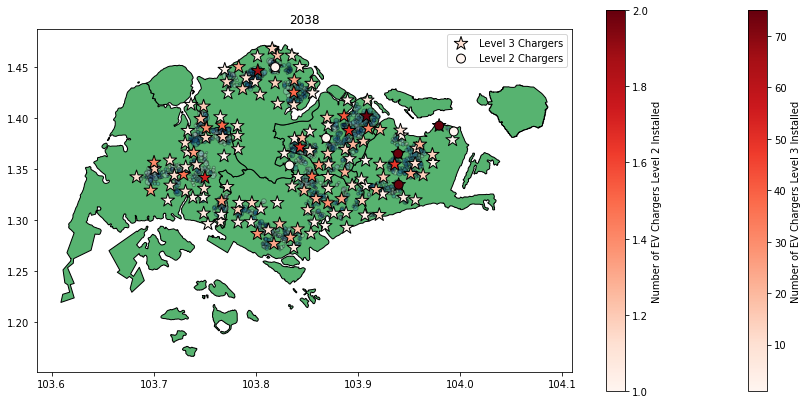

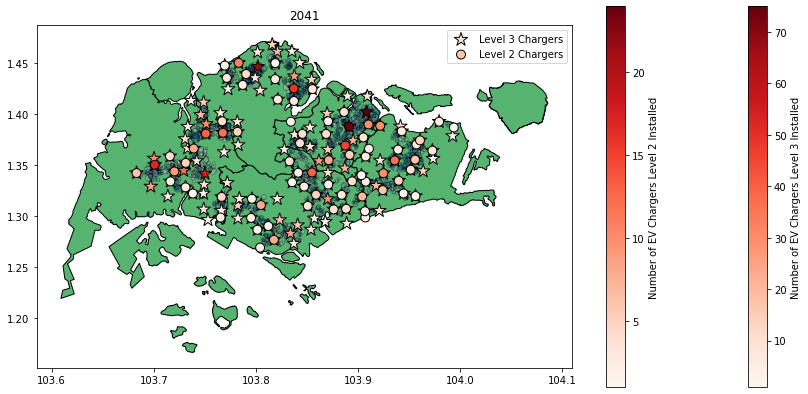

In [33]:
plot_custom(C2_ans[1], C3_ans[1], 2023 + 1 - 1)
plot_custom(C2_ans[6], C3_ans[6], 2023 + 6 - 1)
plot_custom(C2_ans[-4], C3_ans[-4], 2023 + len(C2_ans) - 4 - 1)
plot_custom(C2_ans[-1], C3_ans[-1], 2023 + len(C2_ans) - 1 - 1)

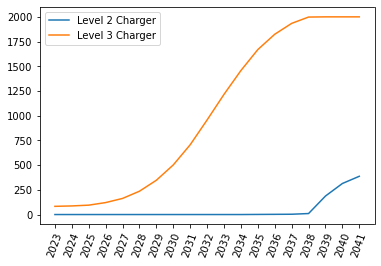

In [34]:
C2_sum = []
for i in range(len(C2_ans)):
    C2_sum.append(C2_ans[i].sum())

C3_sum = []
for i in range(len(C3_ans)):
    C3_sum.append(C3_ans[i].sum())

plt.plot(list(range(2023, 2042)), C2_sum[1:], label = "Level 2 Charger")
plt.plot(list(range(2023, 2042)), C3_sum[1:], label = "Level 3 Charger")
plt.legend()
plt.xticks(range(2023, 2042), rotation = 70)
plt.show()

In [35]:
C2_nonzeros = [x for x in C2_ans[-1] if x > 0]
C3_nonzeros = [x for x in C3_ans[-1] if x > 0]
print(len(C2_nonzeros))
print(len(C3_nonzeros))

80
142
